# 載入所需套件

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.special import comb
from math import log,sqrt,exp
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

#設定字體和解決圖像中文顯示問題
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus']=False

# 定義BS模型函數

In [2]:
#利用math和scipy
def bsm(S,K,r,T,sigma):
    d1=(log(S/K)+(r+0.5*sigma**2))/(sigma*sqrt(T))
    d2=d1-sigma*sqrt(T)
    
    C=S*norm.cdf(d1)-K*exp(-r*T)*norm.cdf(d2)
    
    return C

In [3]:
#利用numpy和scipy
def BSM(S,K,r,T,sigma):
    d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    
    C=S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    
    return C

# 定義CRR模型函數

In [4]:
#利用math和scipy
def crrm(S,K,r,T,sigma,n):
    t=T/n
    u=exp(sigma*sqrt(t))
    d=1/u
    p=(exp(r*t)-d)/(u-d)
    FV=0
    
    for i in range(0,n+1):
        FV+=comb(n,i)*((p**(n-i))*(1-p)**i)*max(S*(u**(n-i))*(d**(i))-K,0)
    
    C=exp(-r*T)*FV
        
    return C

In [5]:
#利用numpy和scipy
def CRRM(S,K,r,T,sigma,n):
    t=T/n
    u=np.exp(sigma*np.sqrt(t))
    d=1/u
    p=(np.exp(r*t)-d)/(u-d)
    FV=0
    
    for i in range(0,n+1):
        FV+=comb(n,i)*((p**(n-i))*(1-p)**i)*np.maximum(S*(u**(n-i))*(d**(i))-K,0)
    
    C=np.exp(-r*T)*FV
        
    return C

# 定義繪製CRR模型收斂至BS模型圖函數

In [6]:
def plot_BS_CRR(S,K,r,T,sigma,n):
    V_CRR=np.zeros(n)
    V_BSM=np.zeros(n)
    n_range=np.arange(1,n+1,1)

    for i in range(1,n+1):
        V_CRR[i-1]=CRRM(S,K,r,T,sigma,i)
        V_BSM[i-1]=BSM(S,K,r,T,sigma)

        
    fig,ax=plt.subplots(1,figsize=(10,5))
    ax.plot(n_range,V_CRR,label='CRR模型')
    ax.plot(n_range,V_BSM,label='BS模型')
    ax.set_xlabel('模擬期數',fontsize=12)
    ax.set_ylabel('價格',fontsize=12)
    ax.set_title('歐式選擇權 CRR模型收斂至BS模型圖',fontsize=15)
    ax.legend(loc='upper right')
    ax.tick_params(axis='x',labelsize=12)
    ax.tick_params(axis='y',labelsize=12)
    ax.grid()
    plt.show()

# 繪製CRR模型收斂至BS模型圖

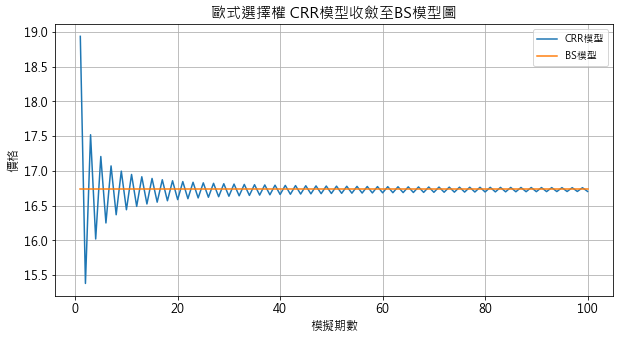

In [7]:
(S,K,r,T,sigma,n)=(100,100,0.1,1,0.3,100)
plot_BS_CRR(S,K,r,T,sigma,n)

# 定義Monte Carlo模擬函數

In [8]:
def Monte_Carlo(S,K,T,r,sigma,numOfPath=5000):
    #N(0,1)亂數產生
    randomSeries=np.random.normal(loc=0,scale=1,size=numOfPath)
    S_T=S*np.exp((r-0.5*sigma**2)*T+sigma*np.sqrt(T)*randomSeries)
    
    C=(np.exp(-r*T)*np.maximum(S_T-K,0.0)).mean()
    
    return C

# 定義繪製Monte Carlo模擬選擇權價格信賴區間收斂圖函數

In [9]:
def plot_Monte_Carlo():
    #從1000次模擬到50000次模擬的结果,每次同樣次數的模擬運行100遍
    pathScenario=range(1000,51000,1000)
    numberOfTrials=100

    upper_bound=[]
    lower_bound=[]
    means=[]

    for scenario in tqdm(pathScenario):
        res=np.zeros(numberOfTrials)
        for i in range(numberOfTrials):
            res[i]=Monte_Carlo(S,K,T,r,sigma,numOfPath=scenario)
        means.append(res.mean())
        upper_bound.append(res.mean()+1.96*res.std()/(100)**0.5)
        lower_bound.append(res.mean()-1.96*res.std()/(100)**0.5)

    table=np.array([means,upper_bound,lower_bound]).T
    
    
    fig,ax=plt.subplots(1,figsize=(10,5))
    ax.plot(pathScenario,table)
    ax.set_title('歐式選擇權 蒙地卡羅法模擬價格',fontsize=15)
    ax.set_xlabel('模擬次數',fontsize=12)
    ax.set_ylabel('價格',fontsize=12)
    ax.legend(['均值','95%信賴區間上界','95%信賴區間下界'])
    ax.grid()
    plt.show()

# 繪製Monte Carlo模擬選擇權價格信賴區間收斂圖

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  2.16it/s]


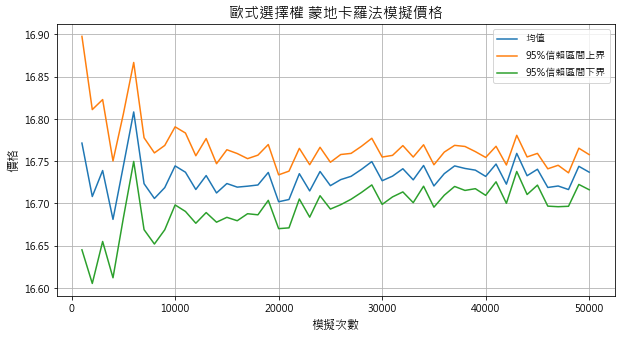

In [10]:
plot_Monte_Carlo()

# 定義計算Greek函數

In [11]:
def Greek(name,S,K,r,T,sigma):
    d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    n_d1=norm.pdf(d1)
    n_d2=norm.pdf(d2)
    N_d1=norm.cdf(d1)
    N_d2=norm.cdf(d2)
    
    Greek_dict={'Delta':lambda:N_d1,
                'Gamma':lambda:(1/(S*sigma*np.sqrt(T)))*n_d1,
                'Vega':lambda:S*np.sqrt(T)*n_d1,
                'Rho':lambda:K*T*np.exp(-r*T)*N_d2,
                'Theta':lambda:-(S*n_d1*(sigma/(2*np.sqrt(T)))+K*r*np.exp(-r*T)*N_d2)}
    
    return Greek_dict.get(name,lambda:'Not a valid Greek')()

# 定義繪製Greek圖形函數

In [12]:
def plot_Greek(S_range,K,r,T,sigma):
    Greek_names=['Delta','Gamma','Vega','Rho','Theta']

    fig,axes=plt.subplots(3,2,figsize=(10,9))
    for i,name in enumerate(Greek_names):
        V_Greek=np.zeros(len(S_range))
        for j,S in enumerate(S_range):
            V_Greek[j]=Greek(name,S,K,r,T,sigma)

        axes[int(i/2),int(i%2)].plot(S_range,V_Greek)
        axes[int(i/2),int(i%2)].set_title('歐式選擇權 {}'.format(name),fontsize=15)
        axes[int(i/2),int(i%2)].set_xlabel('標的股價',fontsize=12)
        axes[int(i/2),int(i%2)].xaxis.set_label_coords(1.01,-0.15)
        axes[int(i/2),int(i%2)].grid()
        plt.tight_layout()
    
    axes[2,1].set_visible(False)
    
    plt.show()    

# 繪製Greek圖形

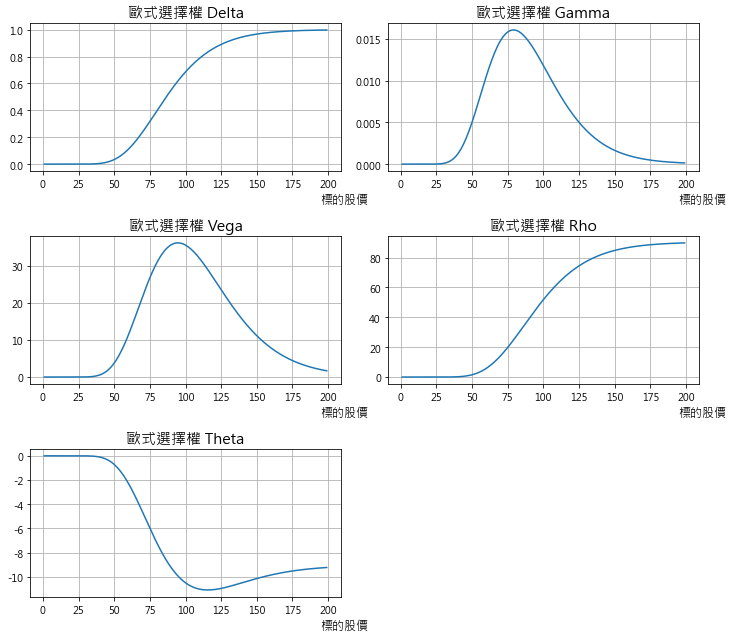

In [13]:
S_range=np.arange(1,200,1)
(K,r,T,sigma)=(100,0.1,1,0.3)
plot_Greek(S_range,K,r,T,sigma)